In [12]:
# Automatically reload imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import sys
sys.path.append('..')  # Add parent directory to Python path
from util.data_preprocessing import pad_data_to_30x30, visualize_grid, encode_grid
from util.model import EnhancedMultiChannelCNN, train_model, train_memory, visualize_memory, visualize_prediction, visualize_actual

In [14]:
data_path = os.path.join('..', 'data', 'training', '0a938d79.json')

with open(data_path, 'r') as f:
  data = json.load(f)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Create tensors directly on GPU
X = torch.tensor([encode_grid(pad_data_to_30x30(ex['input'])) for ex in data['train']]).to(device)
Y = torch.tensor([encode_grid(pad_data_to_30x30(ex['output'])) for ex in data['train']]).to(device)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create model and explicitly move to GPU
model = EnhancedMultiChannelCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)

# Create memory tensor directly on GPU
memory = torch.rand(30, 30, device=device) * 2 - 1

# Verify everything is on GPU
print(f"Using device: {device}")
print(f"Memory tensor device: {memory.device}")
print(f"Model device: {next(model.parameters()).device}")

Using device: cuda
Memory tensor device: cuda:0
Model device: cuda:0


In [19]:
train_memory(model, memory, dataloader, criterion)
train_model(model, memory, dataloader, criterion)

Epoch [100/1000], Loss: 0.0059
Epoch [200/1000], Loss: 0.0056
Epoch [300/1000], Loss: 0.0055
Epoch [400/1000], Loss: 0.0054
Epoch [500/1000], Loss: 0.0053
Epoch [600/1000], Loss: 0.0052
Epoch [700/1000], Loss: 0.0051
Epoch [800/1000], Loss: 0.0051
Epoch [900/1000], Loss: 0.0050
Epoch [1000/1000], Loss: 0.0050
Epoch [10/100], Loss: 0.1287
Epoch [20/100], Loss: 0.0795
Epoch [30/100], Loss: 0.0491
Epoch [40/100], Loss: 0.0276
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0060
Epoch [70/100], Loss: 0.0026
Epoch [80/100], Loss: 0.0013
Epoch [90/100], Loss: 0.0007
Epoch [100/100], Loss: 0.0004


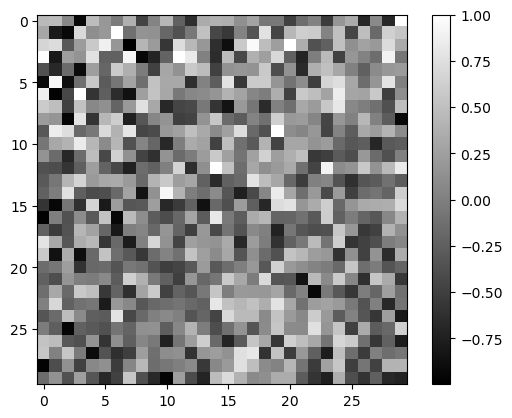

In [20]:
visualize_memory(memory)

In [11]:
# Save the trained model
torch.save(model.state_dict(), 'linear_static_dictionary.pth')

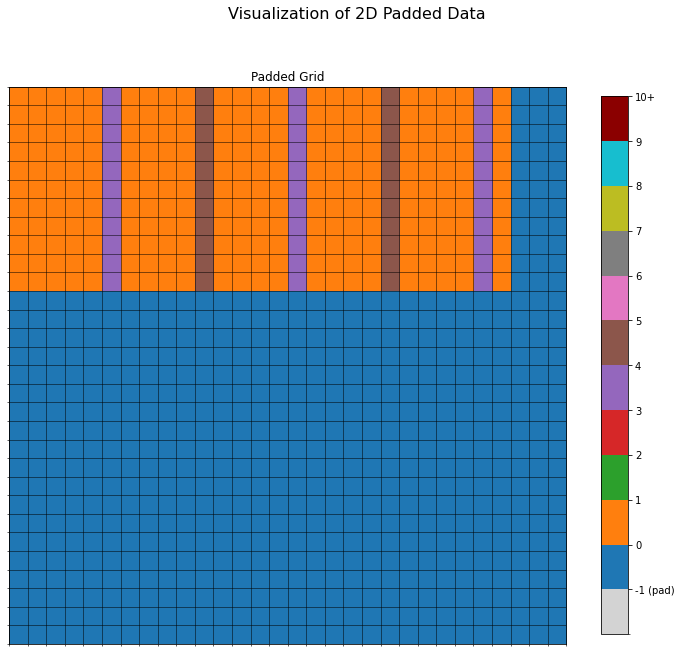

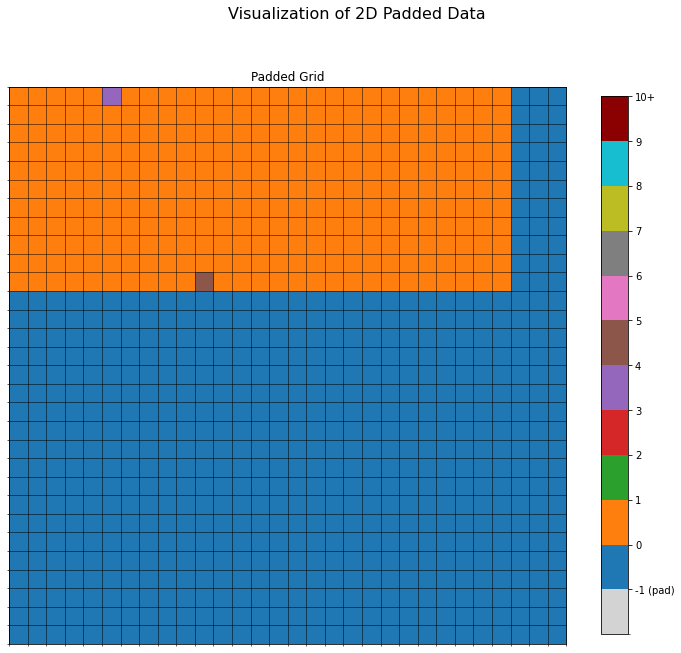

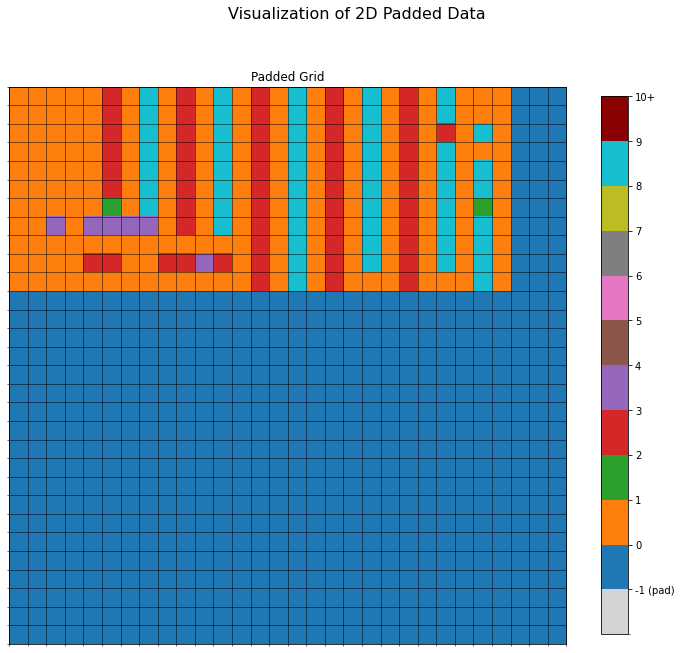

In [248]:
x_test = data['test'][0]
visualize_actual(x_test)
visualize_prediction(x_test['input'], model, memory)
